In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scp
import nltk
import imageio
import sklearn

from matplotlib.pyplot import imshow
from collections import Counter
from timeit import default_timer as timer

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import json as js

import geopandas as gp

%matplotlib inline

# Project
### Stages

**Timetable**

| Time | Task |
|----|----|
|9.9. | Groups deadline |
|16.9.| Topics deadline |
| here | EDA, clean data, do project |
|vk42 | presentation |
|vk43 | projektit |

## Project
```
A. Title of the project	
            
B. Elevator pitch [max 400 characters]
 
Describe the data science challenges related to the following themes. 
A good project should include interesting challenges under most of 
the themes. So for example, a project that begins with a single clean
data set and a clear task (e.g., predict a given response), isn't a good 
choice for your project.		
            
C. Data: sources, wrangling, management		
            
D. Data analysis: statistics, machine learning	
            
E. Communication of results: summarization & visualization
            
F. Operationalization: creating added value, end-user point of view
```

- 4x20x10000 stuctures with 19-30 atoms in a cluster
    - coordinates
    - dipole moment
    - energy
- Goals
    - End user
        - Configuration Sampling 
            - Find one structure with the lowest energy
    - Eliminate redundant structures
    - Find descriptors
        - reduce dimensions
    

## Pitch talk 3min

- Sell oriented
    - Not technical
- Slides, picures, figures
    - Why useful
    - Why interesting
- Any person or all

> We could make video from screenshots describing the problem

> Check project-instructions for deadlines (tue 22.10. klo 23.59)

#### Read data in

Data must have a `.csv`-file that contains:

| col1 | col2 | col3 | col4 | col5 |
|------|------|------|------|------|
| Filename | path to .log-file | path to .xyz-file | Dipole moment | Energy |

Make the csv-file 
> Maybe later

Should read one sample xyz-file to construct headers and get shapes to an array

In [2]:
def init_DF(csvfile):
    "Reads a xyz-file and initializes the dataframe."
    
    filescsv = pd.read_csv(csvfile)
    xyz_temp = filescsv.iloc[0,2]  # to get one xyz(path) as a reference
    
    xyz_test = read_xyz(xyz_temp,False) # Read it to a DF
    
    #filenames = filescsv.iloc[:,0] # Take this one with init_xyz_flatrray()
    n_atoms = xyz_test.index.size
    atomnames = np.array(xyz_test.index)
    
    list_atomnames = []
    for i,j in enumerate(atomnames):
        list_atomnames.append("{}_{}".format(j,i))
    arr_atomnames = np.array(list_atomnames)
    
    col_names = makeMultiIndexs(arr_atomnames)

    arr_clusters,filenames = init_xyz_array(filescsv,n_atoms) # to have the actual data
    
    coord_df = pd.DataFrame(arr_clusters,index=filenames,columns=col_names)
    
    
    return coord_df

In [3]:
def init_xyz_array(filecsv, n_atoms):
    "Reads paths from .csv and returns an array with all coords in rows, and the filenames for DF indexes"
    arr_clusters = np.zeros((1,3*n_atoms+2))
    filenames = np.array(filecsv.Filename)
    for index, row in filecsv.iterrows():
        #filename = row.Filename
        dipole = row.Dipole
        energy = row.Energy
        metarr = np.array([energy,dipole])
        path = row.XYZPath
        xyzs = read_xyz(path) #flatten=True by default

        if index == None:
            print("Filename:",filename)
            print("metarr:",metarr)
            print("shape:",metarr.shape)
            print("type:",type(metarr))
            print("path:",path)
            print("coordshape:",xyzs.shape)
            print("coords:",xyzs)
        
        arrr = np.array(list(metarr)+list(xyzs))
        arr_clusters = np.vstack((arr_clusters,arrr))
    return arr_clusters[1:,:], filenames

In [4]:
def read_xyz(xyzfile,flatten=True):
    """
    usage: read_xyz(xyzfile,flatten(Default=True))
    
    Reads a xyz-file and returns the coordinates as DF
    or flattened to a Numpy-array
    """
    xyz_temp = pd.read_csv(xyzfile, \
                       sep='\s+', \
                       skiprows=2, \
                       header=None, \
                       index_col=0, \
                       names=['x','y','z']\
                      ).sort_index(ascending=False)
    
    if flatten==True:
        xyz_flat = xyz_temp.values.flatten().reshape(1,57)#.astype(np.float)
        return xyz_flat[0]
    else:
        return xyz_temp

In [5]:
def makeMultiIndexs(arr):
    """
    Gets names of atoms as array and makes a pandas multi-indexing structure
    with x-, y- and z- columns for each atom.
    """
    top_arr = np.empty((arr.size * 3 +2)).astype(str)
    top_arr[0] = "Properties"
    top_arr[1] = "Properties"
    top_arr[2::3] = arr
    top_arr[3::3] = arr
    top_arr[4::3] = arr
    butt_arr = np.empty((arr.size * 3 +2)).astype(str)
    butt_arr[0] = "Energy"
    butt_arr[1] = "Dipole"
    butt_arr[2::3] = "x"
    butt_arr[3::3] = "y"
    butt_arr[4::3] = "z"
    col_arr = np.vstack((top_arr,butt_arr))
    #col_arr.transpose()
    col_arr_tuples = list(zip(*col_arr))
    col_names = pd.MultiIndex.from_tuples(col_arr_tuples, names=["Atom","Coord"])
    return col_names

In [6]:
clusters_df = init_DF("Data1/Data_Collection.csv")

In [7]:
#from multi-index to one index
clusters_df.columns = ['_'.join(col) for col in clusters_df.columns.values]

In [20]:
clusters_df.sample(6)

,Properties_Energy,Properties_Dipole,S_0_x,S_0_y,S_0_z,O_1_x,O_1_y,O_1_z,O_2_x,O_2_y,...,H_15_z,H_16_x,H_16_y,H_16_z,H_17_x,H_17_y,H_17_z,H_18_x,H_18_y,H_18_z
6323,-40.924539,1.578,-0.732561,-1.107435,0.748407,0.970614,1.545924,-1.180141,1.266253,-0.908754,...,-0.970411,1.175595,0.571748,-1.504437,1.202003,-1.223032,-0.734016,0.443668,-1.215908,-2.068929
2356,-40.921741,2.756,-0.633089,-0.097471,0.626388,1.982748,-2.339769,-0.621845,1.115037,-0.333702,...,0.140270,1.556772,0.407602,-1.658289,1.557595,-1.148960,-1.804169,-0.104917,-0.385642,-1.472659
390,-40.918934,2.305,1.314052,0.779687,0.822241,1.106020,-0.614963,-1.802678,-2.034796,0.249276,...,-2.759032,-1.187168,0.841624,0.440330,-1.895704,0.108211,-0.852611,-1.844403,-0.651157,0.615728
8521,-40.921589,2.166,1.207232,-0.003586,-0.849184,-1.719470,-1.139103,0.409807,-1.151683,1.159497,...,-2.286355,-0.526218,1.323232,0.348036,-1.565501,0.204796,0.925847,-0.483519,0.954995,1.918430
3462,-40.918556,3.628,0.535077,0.004270,1.033820,-1.106235,2.219809,2.382743,-1.461089,-2.001740,...,-2.455951,-2.420207,-1.957568,-0.752871,-1.141641,-1.326401,-1.426136,-0.906557,-1.499363,0.527811
3658,-40.916691,2.240,0.356129,-0.609553,-1.341775,-1.795093,1.901900,1.281754,-0.281272,-0.181569,...,1.392202,-0.751304,-0.728417,0.457485,0.551063,0.186941,1.463047,-0.901022,0.591173,1.825736


## Data exploration

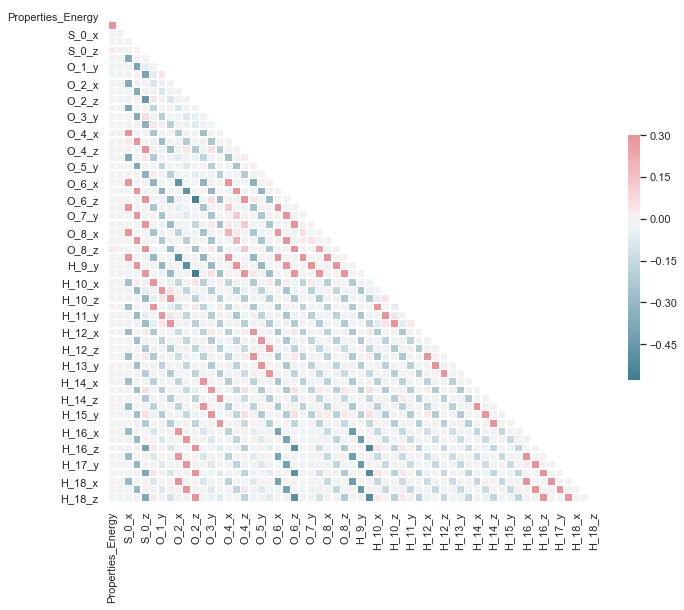

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = clusters_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


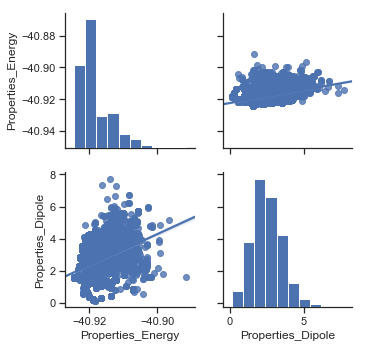

In [22]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(clusters_df,  kind="reg",vars=['Properties_Energy','Properties_Dipole'])

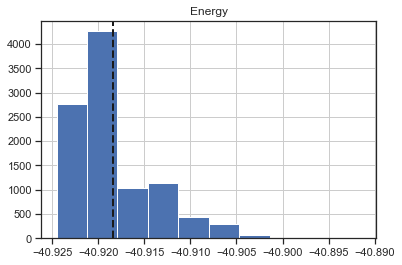

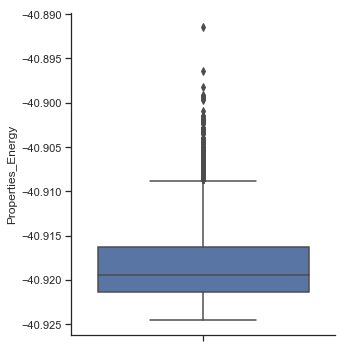

In [23]:
clusters_df['Properties_Energy'].hist()
plt.title("Energy")
plt.axvline(np.mean(clusters_df['Properties_Energy']), color='k', linestyle='dashed', linewidth=2)

sns.catplot( y="Properties_Energy", kind="box", data=clusters_df)
plt.show()

## Linear regression
We can implemente a linear regression model to predict the energy (y)of our cluster wrt to the coordinates variable (X).


In [24]:
clusters_df.loc[range(5),:]

,Properties_Energy,Properties_Dipole,S_0_x,S_0_y,S_0_z,O_1_x,O_1_y,O_1_z,O_2_x,O_2_y,...,H_15_z,H_16_x,H_16_y,H_16_z,H_17_x,H_17_y,H_17_z,H_18_x,H_18_y,H_18_z
0,-40.917924,2.402,0.141169,0.586462,-1.579178,1.571959,0.634674,1.587390,-0.496376,-0.793090,...,-0.603801,0.369601,-0.238477,1.922843,-1.215370,-0.160903,1.456282,-0.303001,-1.543416,1.207911
1,-40.916876,2.607,0.532400,0.529017,-1.645222,1.375753,0.925034,1.661882,-0.636579,-0.551587,...,-0.590325,0.204524,0.070750,1.907475,-1.381973,-0.021312,1.431595,-0.402779,-1.345929,1.296041
2,-40.917924,2.399,0.411648,0.774200,-1.445017,1.090589,1.193316,1.564453,-0.541489,-0.670648,...,0.501951,0.124739,0.152353,1.893355,-1.373890,-0.388308,1.376759,-0.095197,-1.404396,1.380670
3,-40.918934,2.307,1.126023,-0.412876,-1.253473,-0.426702,2.059957,-0.655682,-0.251529,-0.760866,...,-0.513367,-0.412030,0.254635,2.023950,-1.049674,-1.119570,1.360355,0.546613,-0.786457,1.181696
4,-40.918934,2.307,0.417969,-0.742542,1.511013,0.781689,1.806020,-1.803510,0.223932,-0.656572,...,1.322415,-0.780911,-0.732297,-1.749327,0.439209,0.354772,-2.003723,0.665441,-0.931049,-1.000398


In [25]:
energy=clusters_df['Properties_Energy']
coord=clusters_df.drop(['Properties_Energy','Properties_Dipole'],1) #dipole? in or out?

In [26]:
#divide the dataset in train and test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(coord,energy,test_size=0.20)

In [27]:
#linear regression model on train set
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [32]:
model.coef_
r_sq = model.score(x_train, y_train)
r_sq #all variance of data is explained by the dataset, more features than obs 

0.01086304350939371

In [33]:
#predict from the test
y_pred = model.predict(x_test)
pred_test = pd.DataFrame({'Actual': y_test.values.flatten(), 'Predicted': y_pred.flatten()})
pred_test
#it works too well, since we have more variables than observations

,Actual,Predicted
0,-40.920218,-40.918650
1,-40.923437,-40.918203
2,-40.922469,-40.918449
3,-40.916384,-40.918419
4,-40.921398,-40.918073
5,-40.917924,-40.918048
6,-40.918934,-40.918499
7,-40.918934,-40.917785
8,-40.921136,-40.918887
9,-40.918556,-40.918285


In [34]:
#feature selection alternative
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

estimator = SVR(kernel="linear")
selector = RFE(estimator, 5, step=1)
selector = selector.fit(x_train, y_train)
print(selector.support_) 
print(selector.ranking_)


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True  True  True  True  True]
[53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30
 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6
  5  4  3  2  1  1  1  1  1]


In [37]:
#oxigen O8 seems the most significant variable in our model
model1 = LinearRegression().fit(x_train.loc[:,('O 1_y','O 8_x')], y_train) #select the most significant variables...
print('R2 simple reg',model1.score(x_train.loc[:,('O 1_y','O 8_x')], y_train))

KeyError: "None of [('O 1_y', 'O 8_x')] are in the [columns]"

## Principal Component Analysis
To reduce the dimentionality of our data, we will apply PCA to our coordinates variable, in order to select new variables, that explain at least 80% of the variability of our data.

In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
principalComponents = pca.fit_transform(coord)
principalDf = pd.DataFrame(data = principalComponents , columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'])
print('Explained variance (%) :', np.sum(pca.explained_variance_ratio_))

Explained variance (%) : 0.6429207117477929


Explained variance PC1(%) : 0.10069204086633599
Explained variance PC2(%) : 0.09099196688468619


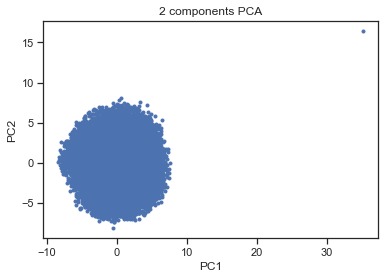

In [39]:
#2D graph of first two PCs
print('Explained variance PC1(%) :', pca.explained_variance_ratio_[0])
print('Explained variance PC2(%) :', pca.explained_variance_ratio_[1])

plt.plot(principalDf['PC1'] , principalDf['PC2'], '.')
plt.title("2 components PCA")
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

## K-means
It's time to cluster the clusters, we can use a k-mean algorith.

In [40]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)  #we should chose the number of clusters
kmeans.fit(clusters_df)
y_kmeans = kmeans.predict(clusters_df)

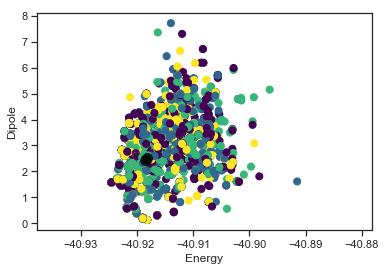

In [41]:
plt.scatter(clusters_df['Properties_Energy'], clusters_df['Properties_Dipole'], c=y_kmeans,s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)
plt.xlabel('Energy')
plt.ylabel('Dipole')
plt.show()

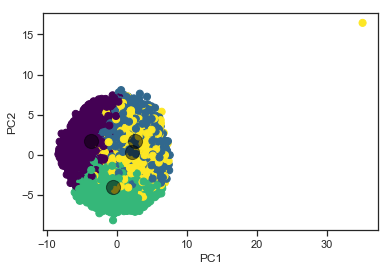

In [42]:
#clustering using PCS as variables
finalDf = pd.concat([principalDf, clusters_df[['Properties_Energy']]], axis = 1)
finalDf = pd.concat([finalDf, clusters_df[['Properties_Dipole']]], axis = 1)
kmeans.fit(finalDf)
y_kmeans = kmeans.predict(finalDf)
plt.scatter(finalDf['PC1'], finalDf['PC2'], c=y_kmeans,s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

***
***
***
***
***
***
***
***
***
***
***
***

In [43]:
files = pd.read_csv("Data_Collection.csv")
np.array(files.Filename)

array([ 0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  1, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  2, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  3,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  4,  5,  6,  7,  8,  9])

In [44]:
test = next(files.iterrows())[1]
print(test)
type(test.Filename)

Filename                      0
LogPath      ./Data1/logs/0.log
XYZPath     ./Data1/coord/0.xyz
Dipole                    2.402
Energy                 -40.9179
Name: 0, dtype: object


int

In [45]:
xyz_test = pd.read_csv("Data1/coord/0.xyz", \
                       sep='\s+', \
                       skiprows=2, \
                       header=None, \
                       index_col=0, \
                       names=['x','y','z']\
                      ).sort_index(ascending=False)
# Atom names in indexes

```python
xyz_test = pd.read_csv("Data1/0.xyz", \
                       sep='\s+',\
                       skiprows=2, \
                       header=None, \
                       names=['atom','x','y','z']\
                      ).sort_values(by='atom',ascending=False).reset_index(drop=True)
# Atom names in col 0
```


Print the names of the atoms

> How is order handled under one label?
- what is the order of other coord files?

Save the names of the atoms to an array

In [46]:
arr_indexes = np.array(xyz_test.index)

In [47]:
arr_indexes.shape[0]

19

Get numbers for the atoms and concatenate them with the labels

In [48]:
list_atomnames = []

for i,j in enumerate(arr_indexes):
    list_atomnames.append("{} {}".format(j,i))

arr_atomnames = np.array(list_atomnames)

Make the multi-index array of tuples

In [49]:
top_arr = np.empty((arr_atomnames.size * 3)).astype(str)
top_arr[0::3] = arr_atomnames
top_arr[1::3] = arr_atomnames
top_arr[2::3] = arr_atomnames
#top_arr

In [50]:
butt_arr = np.empty((arr_atomnames.size * 3)).astype(str)
butt_arr[0::3] = "x"
butt_arr[1::3] = "y"
butt_arr[2::3] = "z"
#butt_arr

In [51]:
col_arr = np.vstack((top_arr,butt_arr))
#col_arr.transpose()
col_arr_tuples = list(zip(*col_arr))
col_arr_tuples[:5]

[('S 0', 'x'), ('S 0', 'y'), ('S 0', 'z'), ('O 1', 'x'), ('O 1', 'y')]

Multi-index column names

In [52]:
col_names = pd.MultiIndex.from_tuples(col_arr_tuples, names=["Atom","Coord"])
col_names

MultiIndex(levels=[['H 10', 'H 11', 'H 12', 'H 13', 'H 14', 'H 15', 'H 16', 'H 17', 'H 18', 'H 9', 'O 1', 'O 2', 'O 3', 'O 4', 'O 5', 'O 6', 'O 7', 'O 8', 'S 0'], ['x', 'y', 'z']],
           labels=[[18, 18, 18, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 9, 9, 9, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8], [0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]],
           names=['Atom', 'Coord'])

In [53]:
3*19

57

In [54]:
xyz_test.values.flatten().shape

(57,)

In [55]:
xyz_flat = xyz_test.values.flatten().reshape(1,57)

In [56]:
type(xyz_flat)

numpy.ndarray

In [57]:
coord_df = pd.DataFrame(xyz_flat,index=['a'],columns=col_names)
with pd.option_context('display.max_rows',None,'display.max_columns',None):
    print(coord_df)

Atom        S 0                           O 1                          O 2  \
Coord         x         y         z         x         y        z         x   
a      0.141169  0.586462 -1.579178  1.571959  0.634674  1.58739 -0.496376   

Atom                           O 3                          O 4            \
Coord        y         z         x         y         z        x         y   
a     -0.79309  1.912224  0.122061 -2.393288  0.079677  1.01335 -0.572018   

Atom                  O 5                          O 6                      \
Coord         z         x         y        z         x         y         z   
a     -1.481227 -1.989939  0.798705  0.68009  0.522933  1.346199 -2.915277   

Atom        O 7                           O 8                          H 9  \
Coord         x         y         z         x        y         z         x   
a      0.369189  1.535905 -0.499852 -1.256258  0.20951 -1.702193  0.192515   

Atom                           H 10                          H 

In [58]:
coord_df

Atom        S 0                           O 1                          O 2  \
Coord         x         y         z         x         y        z         x   
a      0.141169  0.586462 -1.579178  1.571959  0.634674  1.58739 -0.496376   

Atom                           O 3    ...         H 15      H 16            \
Coord        y         z         x    ...            z         x         y   
a     -0.79309  1.912224  0.122061    ...    -0.603801  0.369601 -0.238477   

Atom                H 17                          H 18                      
Coord         z        x         y         z         x         y         z  
a      1.922843 -1.21537 -0.160903  1.456282 -0.303001 -1.543416  1.207911  

[1 rows x 57 columns]